In [75]:
import skimage.data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import selectivesearch
from selectivesearch import _generate_segments, _extract_regions,_extract_neighbours,_calc_sim,_merge_regions
import cv2
from IPython.display import Image as img_display

In [76]:
# loading astronaut image
img = skimage.data.astronaut()

#path='/notebooks/selectivesearch/'
#cv2.imwrite(path+"img.png",img)
#img_display(filename=path+"img.png")

In [77]:
im_orig=img
scale=500
sigma=0.9
min_size=10
# load image and get smallest regions
# region label is stored in the 4th value of each pixel [r,g,b,(region)]
img = _generate_segments(im_orig, scale, sigma, min_size)

# if img is None:
#     return None, {}

imsize = img.shape[0] * img.shape[1]
R = _extract_regions(img)

# extract neighbouring information
# neighbours = _extract_neighbours(R)

def intersect(a, b):
    if (a["min_x"] < b["min_x"] < a["max_x"]
            and a["min_y"] < b["min_y"] < a["max_y"]) or (
        a["min_x"] < b["max_x"] < a["max_x"]
            and a["min_y"] < b["max_y"] < a["max_y"]) or (
        a["min_x"] < b["min_x"] < a["max_x"]
            and a["min_y"] < b["max_y"] < a["max_y"]) or (
        a["min_x"] < b["max_x"] < a["max_x"]
            and a["min_y"] < b["min_y"] < a["max_y"]):
        return True
    return False

R_ex = list(R.items())
neighbours = []
for cur, a in enumerate(R_ex[:-1]):
    for b in R_ex[cur + 1:]:
        if intersect(a[1], b[1]):
            neighbours.append((a, b))

# calculate initial similarities
S = {}
for (ai, ar), (bi, br) in neighbours:
    S[(ai, bi)] = _calc_sim(ar, br, imsize)

# hierarchal search
while S != {}:

    # get highest similarity
    i, j = sorted(S.items(), key=lambda a: a[1])[-1][0]

    # merge corresponding regions
    t = max(R.keys()) + 1.0
    R[t] = _merge_regions(R[i], R[j])

    # mark similarities for regions to be removed
    key_to_delete = []
    for k, v in S.items():
        if (i in k) or (j in k):
            key_to_delete.append(k)

    # remove old similarities of related regions
    for k in key_to_delete:
        del S[k]

    # calculate similarity set with the new region
    for k in filter(lambda a: a != (i, j), key_to_delete):
        n = k[1] if k[0] in (i, j) else k[0]
        S[(t, n)] = _calc_sim(R[t], R[n], imsize)

regions = []
for k, r in R.items():
    regions.append({
        'rect': (
            r['min_x'], r['min_y'],
            r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
        'size': r['size'],
        'labels': r['labels']
    })

152 17 147 171
46 0 353 326
366 223 93 81
365 345 129 109
364 345 130 109
32 210 207 213
134 348 77 75
255 216 256 295
32 210 207 228
0 210 356 301
42 210 197 213
46 0 353 351
0 0 511 511
111 150 194 198
134 348 75 75
265 216 246 295


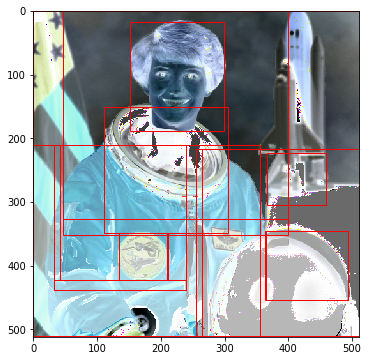

In [78]:
# perform selective search
# img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)
img_lbl=img
candidates = set()
for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue
    # excluding regions smaller than 2000 pixels
    if r['size'] < 2000:
        continue
    # distorted rects
    x, y, w, h = r['rect']
    if w / h > 1.2 or h / w > 1.2:
        continue
    candidates.add(r['rect'])

# draw rectangles on the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

ax.imshow(img)
# cv2.imwrite(pathname+"/blur.png",gray)
# img_display(filename=pathname+"/blur.png")

for x, y, w, h in candidates:
    print (x, y, w, h)
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

plt.show()
